# Kaggle Sberbank Challenge

# Data Import
The data for this challenged was downloaged from the kaggle website.  
https://www.kaggle.com/c/sberbank-russian-housing-market/data


In [164]:
import pandas as pd
import numpy as nd
import matplotlib.pyplot as plt
import xgboost as xgb
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


%pylab
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [165]:
testing = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')
macro = pr.read_csv('./data/macro.csv')

NameError: name 'pr' is not defined

In [ ]:
train.shape

In [ ]:
testing.shape

# Cleaning

Let's see what we have for factors

In [ ]:
train.columns.values

There are a lot of factors here.  I'm going to take a look at the dictionary doc and start working my way through them.


## price, our target variable
Let's look at our target variable and the primary variables first.

In [ ]:
train.price_doc.describe()

In [ ]:
train.price_doc.hist(bins=30, range=[0,3e7])


## id variable
id variable appears to be just an index.  I will drop it from the data.

In [ ]:
train.drop('id', axis=1, inplace=True)
testing.drop('id', axis=1, inplace=True)

## timestamp
The timestamp may or may not be valuable.  Let's pull out the month, day of month and year into seperate columns and take a look at how they are distributed.   

In [ ]:
train['year'], train['month'], train['dayofmon']  = train['timestamp'].str.split('-',2).str
train.drop('timestamp', axis=1, inplace=True)

##for testing data as well
testing['year'], testing['month'], testing['dayofmon']  = testing['timestamp'].str.split('-',2).str
testing.drop('timestamp', axis=1, inplace=True)


In [ ]:
train['year'].astype('int').hist()

In [ ]:
train['month'].astype('int').hist()

In [ ]:
train['dayofmon'].astype('int').hist()

From the year we can see that a lot of our data comes from 2014.  The month and day of month also vary.  Assuming that all sales were recorded it seems like more home sales occur in certain months and on certain days of the month.

In [ ]:
train['year'] = train['year'].astype('category')
train['month'] = train['month'].astype('category')
train['dayofmon'] = train['dayofmon'].astype('category')

##For test data as well
testing['year'] = testing['year'].astype('category')
testing['month'] = testing['month'].astype('category')
testing['dayofmon'] = testing['dayofmon'].astype('category')

## Square meters
There are two variables for size one is the living space and the other includes the full space including "loggias, balconies, and other non-residential areas".

First let's see how different life and full are.  

In [ ]:
train['life_sq'].mean()

In [ ]:
train['full_sq'].mean()

In [ ]:
sqDiff = train['full_sq'].mean() - train['life_sq'].mean()

So the average difference between the life and full is about 20m.  This may be useful.  


Let's check and see if we have any values where life>full.  Something which should not occur by definition.

In [ ]:
train[(train['life_sq'] > train['full_sq'])]

There are 37 columns where this is true.  Some may be erroneous, some may be typos.  I think a good strategy for these would be to set full= life + 20m in these cases below some limit to prevent duplicating likely typos(I see a 7478 in the list) .  

In [ ]:
train['full_sq'] = np.where((train['life_sq'] > train['full_sq']) & (train['life_sq'] < 1000), train['life_sq'] + sqDiff,train['full_sq'])


Now let's look at distribution of the values

In [ ]:
train['full_sq'].hist(bins=30, range=[0,100])

In [ ]:
train['life_sq'].hist(bins=30, range=[0,100])

Looks like we have values at or near zero which is unlikely to be true.  Let's take a look at some.

In [ ]:
train[train['full_sq'] < 10]

I think we can consider these invalid entries.  No apartment is 1 square meter.  Looking at these entries it appears that most of the other columns are missing as well.  Given how incomplete the primary traits are I'm going to drop these rows entirely.  

In [ ]:
#train.drop(train[train.full_sq < 10].index, inplace=True)

Now let's take a look at life_sq

In [ ]:
train[train['life_sq'] < 5]

This looks similar to what we had while looking at cases where life was larger than full.  A lot of columns with 0 or 1. I'm going to apply the same logic and replace life with the full value - difference in means for these.  

In [ ]:
train['life_sq'] = np.where((train['life_sq'] < 5),train['full_sq'] - sqDiff,train['life_sq'])

In [ ]:
train['full_sq'].isnull().sum()

So no null values in full_sq

In [ ]:
train['life_sq'].isnull().sum()

Quite a few in life_sq, approximately 20%.  I've got 2 choices I think.  I can try and impute the missing values or drop this feature entirely assuming that the full_sq footage will capture any of the relationship between square footage and price.  I think for now I will drop life_sq.  I may revisit this later to see if adding it back in helps.  

In [ ]:
#train.drop('life_sq', axis=1, inplace=True)

##for the test data as well
#testing.drop('life_sq', axis=1, inplace=True)

## floor

Now let's take a look at the floor variables, floor and max_floor.

Starting with how many missing values there are and how the data is distributed.  

In [ ]:
train['floor'].hist(bins=30, range=[0,40])

In [ ]:
train['floor'].isnull().sum()

In [ ]:
train['max_floor'].hist(bins=30, range=[0,50])

In [ ]:
train['max_floor'].isnull().sum()

So the floor value only has 167 missing.  Let's take a look.

In [ ]:
train[train['floor'].isnull()]

These records look pretty incomplete in general.  Going to drop these rows for now rather than trying to impute multiple columns.

In [ ]:
#train.drop(train[train['floor'].isnull()].index, inplace=True)

max_floor is missing nearly 1/3 of it's values. Dropping this column for now rather than trying to impute the values.  I may revisit this later.  

In [ ]:
#train.drop('max_floor', axis=1, inplace=True)

##same for testing data
#testing.drop('max_floor', axis=1, inplace=True)

## material

In [ ]:
train['material'].hist(bins=30)

In [ ]:
train['material'].isnull().sum()

So another feature with 1/3 of the values missing.  I will drop it for the moment.  

In [ ]:
#train.drop('material', axis=1, inplace=True)

##same for test data
#testing.drop('material', axis=1, inplace=True)

## build_year

In [ ]:
train['build_year'].hist(bins=30, range=[1900, 2020])

In [ ]:
train['build_year'].isnull().sum()

In [ ]:
train['build_year'].describe()

Lots of missing values on this one as well.  Dropping for the moment

In [ ]:
#train.drop('build_year', axis=1, inplace=True)

## same for test data
#testing.drop('build_year', axis=1, inplace=True)

## num_room

In [ ]:
train['num_room'].hist(bins=30)

In [ ]:
train['num_room'].isnull().sum()

In [ ]:
#train.drop('num_room', axis=1, inplace=True)

##same for testing data
#testing.drop('num_room', axis=1, inplace=True)

## kitch_sq

In [ ]:
train['kitch_sq'].hist(bins=30)

In [ ]:
train['kitch_sq'].isnull().sum()

In [ ]:
#train.drop('kitch_sq', axis=1, inplace=True)

##same for testing data
#testing.drop('kitch_sq', axis=1, inplace=True)

## state

In [ ]:
train['state'].hist(bins=30)

In [ ]:
train['state'].isnull().sum()

In [ ]:
#train.drop('state', axis=1, inplace=True)

##same for test data
#testing.drop('state', axis=1, inplace=True)

## product_type

In [ ]:
train['product_type'].value_counts()

In [ ]:
train['product_type'].isnull().sum()

This one looks good.  Changing it to categorical.

In [ ]:
train['product_type'] = train['product_type'].astype('category')

##same for testing data
testing['product_type'] = testing['product_type'].astype('category')

## sub_area

In [ ]:
train['sub_area'].value_counts()

In [ ]:
train['sub_area'].isnull().sum()

This one looks good. Changing it to categorical.

In [ ]:
train['sub_area'] = train['sub_area'].astype('category')

##same for testing data
testing['sub_area'] = testing['sub_area'].astype('category')

## other variables

There are a ton of other variables in this data set.  Let's first explore how complete each one is.

In [ ]:
features = train.isnull().sum()

In [ ]:
features[features>0]

In [ ]:
#train.dropna(axis=1, inplace=True)
#train.drop('green_part_2000',axis=1, inplace=True)

In [ ]:
#testing.dropna(axis=1, inplace=True)

In [169]:
train.dtypes

id                                         int64
timestamp                                 object
full_sq                                    int64
life_sq                                  float64
floor                                    float64
max_floor                                float64
material                                 float64
build_year                               float64
num_room                                 float64
kitch_sq                                 float64
state                                    float64
product_type                              object
sub_area                                  object
area_m                                   float64
raion_popul                                int64
green_zone_part                          float64
indust_part                              float64
children_preschool                         int64
preschool_quota                          float64
preschool_education_centers_raion          int64
children_school     

# Model Training and testing

Let's build some models and see how they do.  I want to break out some validation data to try out the models.

In [ ]:
##convert some category variables to codes
codes_sub_area = dict(enumerate(train.sub_area.cat.categories)) 
train['sub_area'] = train['sub_area'].cat.codes
codes_product_type = dict(enumerate(train.product_type.cat.categories))
train['product_type'] = train['product_type'].cat.codes
codes_month = dict(enumerate(train.month.cat.categories)) 
train['month'] = train['month'].cat.codes
codes_year = dict(enumerate(train.year.cat.categories)) 
train['year'] = train['year'].cat.codes
codes_dayofmon = dict(enumerate(train.dayofmon.cat.categories)) 
train['dayofmon'] = train['dayofmon'].cat.codes

train['culture_objects_top_25'] = train['culture_objects_top_25'].astype('category')
codes_culture_objects_top_25 = dict(enumerate(train.culture_objects_top_25.cat.categories))
train['culture_objects_top_25'] = train['culture_objects_top_25'].cat.codes

train['thermal_power_plant_raion'] = train['thermal_power_plant_raion'].astype('category')
codes_thermal_power_plant_raion = dict(enumerate(train.thermal_power_plant_raion.cat.categories))
train['thermal_power_plant_raion'] = train['thermal_power_plant_raion'].cat.codes

train['incineration_raion'] = train['incineration_raion'].astype('category')
codes_incineration_raion = dict(enumerate(train.incineration_raion.cat.categories))
train['incineration_raion'] = train['incineration_raion'].cat.codes

train['oil_chemistry_raion'] = train['oil_chemistry_raion'].astype('category')
codes_oil_chemistry_raion = dict(enumerate(train.oil_chemistry_raion.cat.categories))
train['oil_chemistry_raion'] = train['oil_chemistry_raion'].cat.codes

train['radiation_raion'] = train['radiation_raion'].astype('category')
codes_radiation_raion = dict(enumerate(train.radiation_raion.cat.categories))
train['radiation_raion'] = train['radiation_raion'].cat.codes

train['railroad_terminal_raion'] = train['railroad_terminal_raion'].astype('category')
codes_railroad_terminal_raion = dict(enumerate(train.railroad_terminal_raion.cat.categories))
train['railroad_terminal_raion'] = train['railroad_terminal_raion'].cat.codes

train['big_market_raion'] = train['big_market_raion'].astype('category')
codes_big_market_raion = dict(enumerate(train.big_market_raion.cat.categories))
train['big_market_raion'] = train['big_market_raion'].cat.codes

train['nuclear_reactor_raion'] = train['nuclear_reactor_raion'].astype('category')
codes_nuclear_reactor_raion = dict(enumerate(train.nuclear_reactor_raion.cat.categories))
train['nuclear_reactor_raion'] = train['nuclear_reactor_raion'].cat.codes

train['detention_facility_raion'] = train['detention_facility_raion'].astype('category')
codes_detention_facility_raion = dict(enumerate(train.detention_facility_raion.cat.categories))
train['detention_facility_raion'] = train['detention_facility_raion'].cat.codes

train['water_1line'] = train['water_1line'].astype('category')
codes_water_1line = dict(enumerate(train.water_1line.cat.categories))
train['water_1line'] = train['water_1line'].cat.codes

train['big_road1_1line'] = train['big_road1_1line'].astype('category')
codes_big_road1_1line = dict(enumerate(train.big_road1_1line.cat.categories))
train['big_road1_1line'] = train['big_road1_1line'].cat.codes

train['railroad_1line'] = train['railroad_1line'].astype('category')
codes_railroad_1line = dict(enumerate(train.railroad_1line.cat.categories))
train['railroad_1line'] = train['railroad_1line'].cat.codes

train['ecology'] = train['ecology'].astype('category')
codes_ecology = dict(enumerate(train.ecology.cat.categories))
train['ecology'] = train['ecology'].cat.codes


training, validation = train_test_split(train, test_size = 0.2)

training_Y = training['price_doc']
training_X = training.drop('price_doc', axis=1)
validation_Y = validation['price_doc'].values
validation_X = validation.drop('price_doc', axis=1)


In [ ]:
##Same transformations on test data

codest_sub_area = dict(enumerate(testing.sub_area.cat.categories)) 
testing['sub_area'] = testing['sub_area'].cat.codes
codest_product_type = dict(enumerate(testing.product_type.cat.categories))
testing['product_type'] = testing['product_type'].cat.codes
codest_month = dict(enumerate(testing.month.cat.categories)) 
testing['month'] = testing['month'].cat.codes
codest_year = dict(enumerate(testing.year.cat.categories)) 
testing['year'] = testing['year'].cat.codes
codest_dayofmon = dict(enumerate(testing.dayofmon.cat.categories)) 
testing['dayofmon'] = testing['dayofmon'].cat.codes

testing['culture_objects_top_25'] = testing['culture_objects_top_25'].astype('category')
codest_culture_objects_top_25 = dict(enumerate(testing.culture_objects_top_25.cat.categories))
testing['culture_objects_top_25'] = testing['culture_objects_top_25'].cat.codes

testing['thermal_power_plant_raion'] = testing['thermal_power_plant_raion'].astype('category')
codest_thermal_power_plant_raion = dict(enumerate(testing.thermal_power_plant_raion.cat.categories))
testing['thermal_power_plant_raion'] = testing['thermal_power_plant_raion'].cat.codes

testing['incineration_raion'] = testing['incineration_raion'].astype('category')
codest_incineration_raion = dict(enumerate(testing.incineration_raion.cat.categories))
testing['incineration_raion'] = testing['incineration_raion'].cat.codes

testing['oil_chemistry_raion'] = testing['oil_chemistry_raion'].astype('category')
codest_oil_chemistry_raion = dict(enumerate(testing.oil_chemistry_raion.cat.categories))
testing['oil_chemistry_raion'] = testing['oil_chemistry_raion'].cat.codes

testing['radiation_raion'] = testing['radiation_raion'].astype('category')
codest_radiation_raion = dict(enumerate(testing.radiation_raion.cat.categories))
testing['radiation_raion'] = testing['radiation_raion'].cat.codes

testing['railroad_terminal_raion'] = testing['railroad_terminal_raion'].astype('category')
codest_railroad_terminal_raion = dict(enumerate(testing.railroad_terminal_raion.cat.categories))
testing['railroad_terminal_raion'] = testing['railroad_terminal_raion'].cat.codes

testing['big_market_raion'] = testing['big_market_raion'].astype('category')
codest_big_market_raion = dict(enumerate(testing.big_market_raion.cat.categories))
testing['big_market_raion'] = testing['big_market_raion'].cat.codes

testing['nuclear_reactor_raion'] = testing['nuclear_reactor_raion'].astype('category')
codest_nuclear_reactor_raion = dict(enumerate(testing.nuclear_reactor_raion.cat.categories))
testing['nuclear_reactor_raion'] = testing['nuclear_reactor_raion'].cat.codes

testing['detention_facility_raion'] = testing['detention_facility_raion'].astype('category')
codest_detention_facility_raion = dict(enumerate(testing.detention_facility_raion.cat.categories))
testing['detention_facility_raion'] = testing['detention_facility_raion'].cat.codes

testing['water_1line'] = testing['water_1line'].astype('category')
codest_water_1line = dict(enumerate(testing.water_1line.cat.categories))
testing['water_1line'] = testing['water_1line'].cat.codes

testing['big_road1_1line'] = testing['big_road1_1line'].astype('category')
codest_big_road1_1line = dict(enumerate(testing.big_road1_1line.cat.categories))
testing['big_road1_1line'] = testing['big_road1_1line'].cat.codes

testing['railroad_1line'] = testing['railroad_1line'].astype('category')
codest_railroad_1line = dict(enumerate(testing.railroad_1line.cat.categories))
testing['railroad_1line'] = testing['railroad_1line'].cat.codes

testing['ecology'] = testing['ecology'].astype('category')
codest_ecology = dict(enumerate(testing.ecology.cat.categories))
testing['ecology'] = testing['ecology'].cat.codes

## Error calculation
Erorr for this contest is rmsle.  Need to define a funciton for this measurement to test my results.

In [155]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(abs(y_pred[i]) + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

## XGBoost


In [144]:
##Create train and validate DMatrix
trainingXGB = xgb.DMatrix(training_X, label=training_Y)
#validateXGB = xgb.DMatrix(validation_X)

##Set up crossvalidation and build model to test.  
ind_params = {'nthread':3}
cv_params = {'max_depth':[6] , 'learning_rate':[.3], 'n_estimators': [100, 200, 300, 400]}

##Build optimized model with GridSearch
model_xgb = GridSearchCV(xgb.XGBRegressor(**ind_params), cv_params, cv=5, n_jobs=3)
model_xgb.fit(training_X, training_Y)

best_params = model_xgb.best_params_

In [163]:
model_xgb

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=3,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'max_depth': [6], 'learning_rate': [0.3], 'n_estimators': [100, 200, 300, 400]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [156]:
rmsle(validation_Y,predY_xgb)

0.46822064714504635

ValueError: tree must be Booster, XGBModel or dict instance

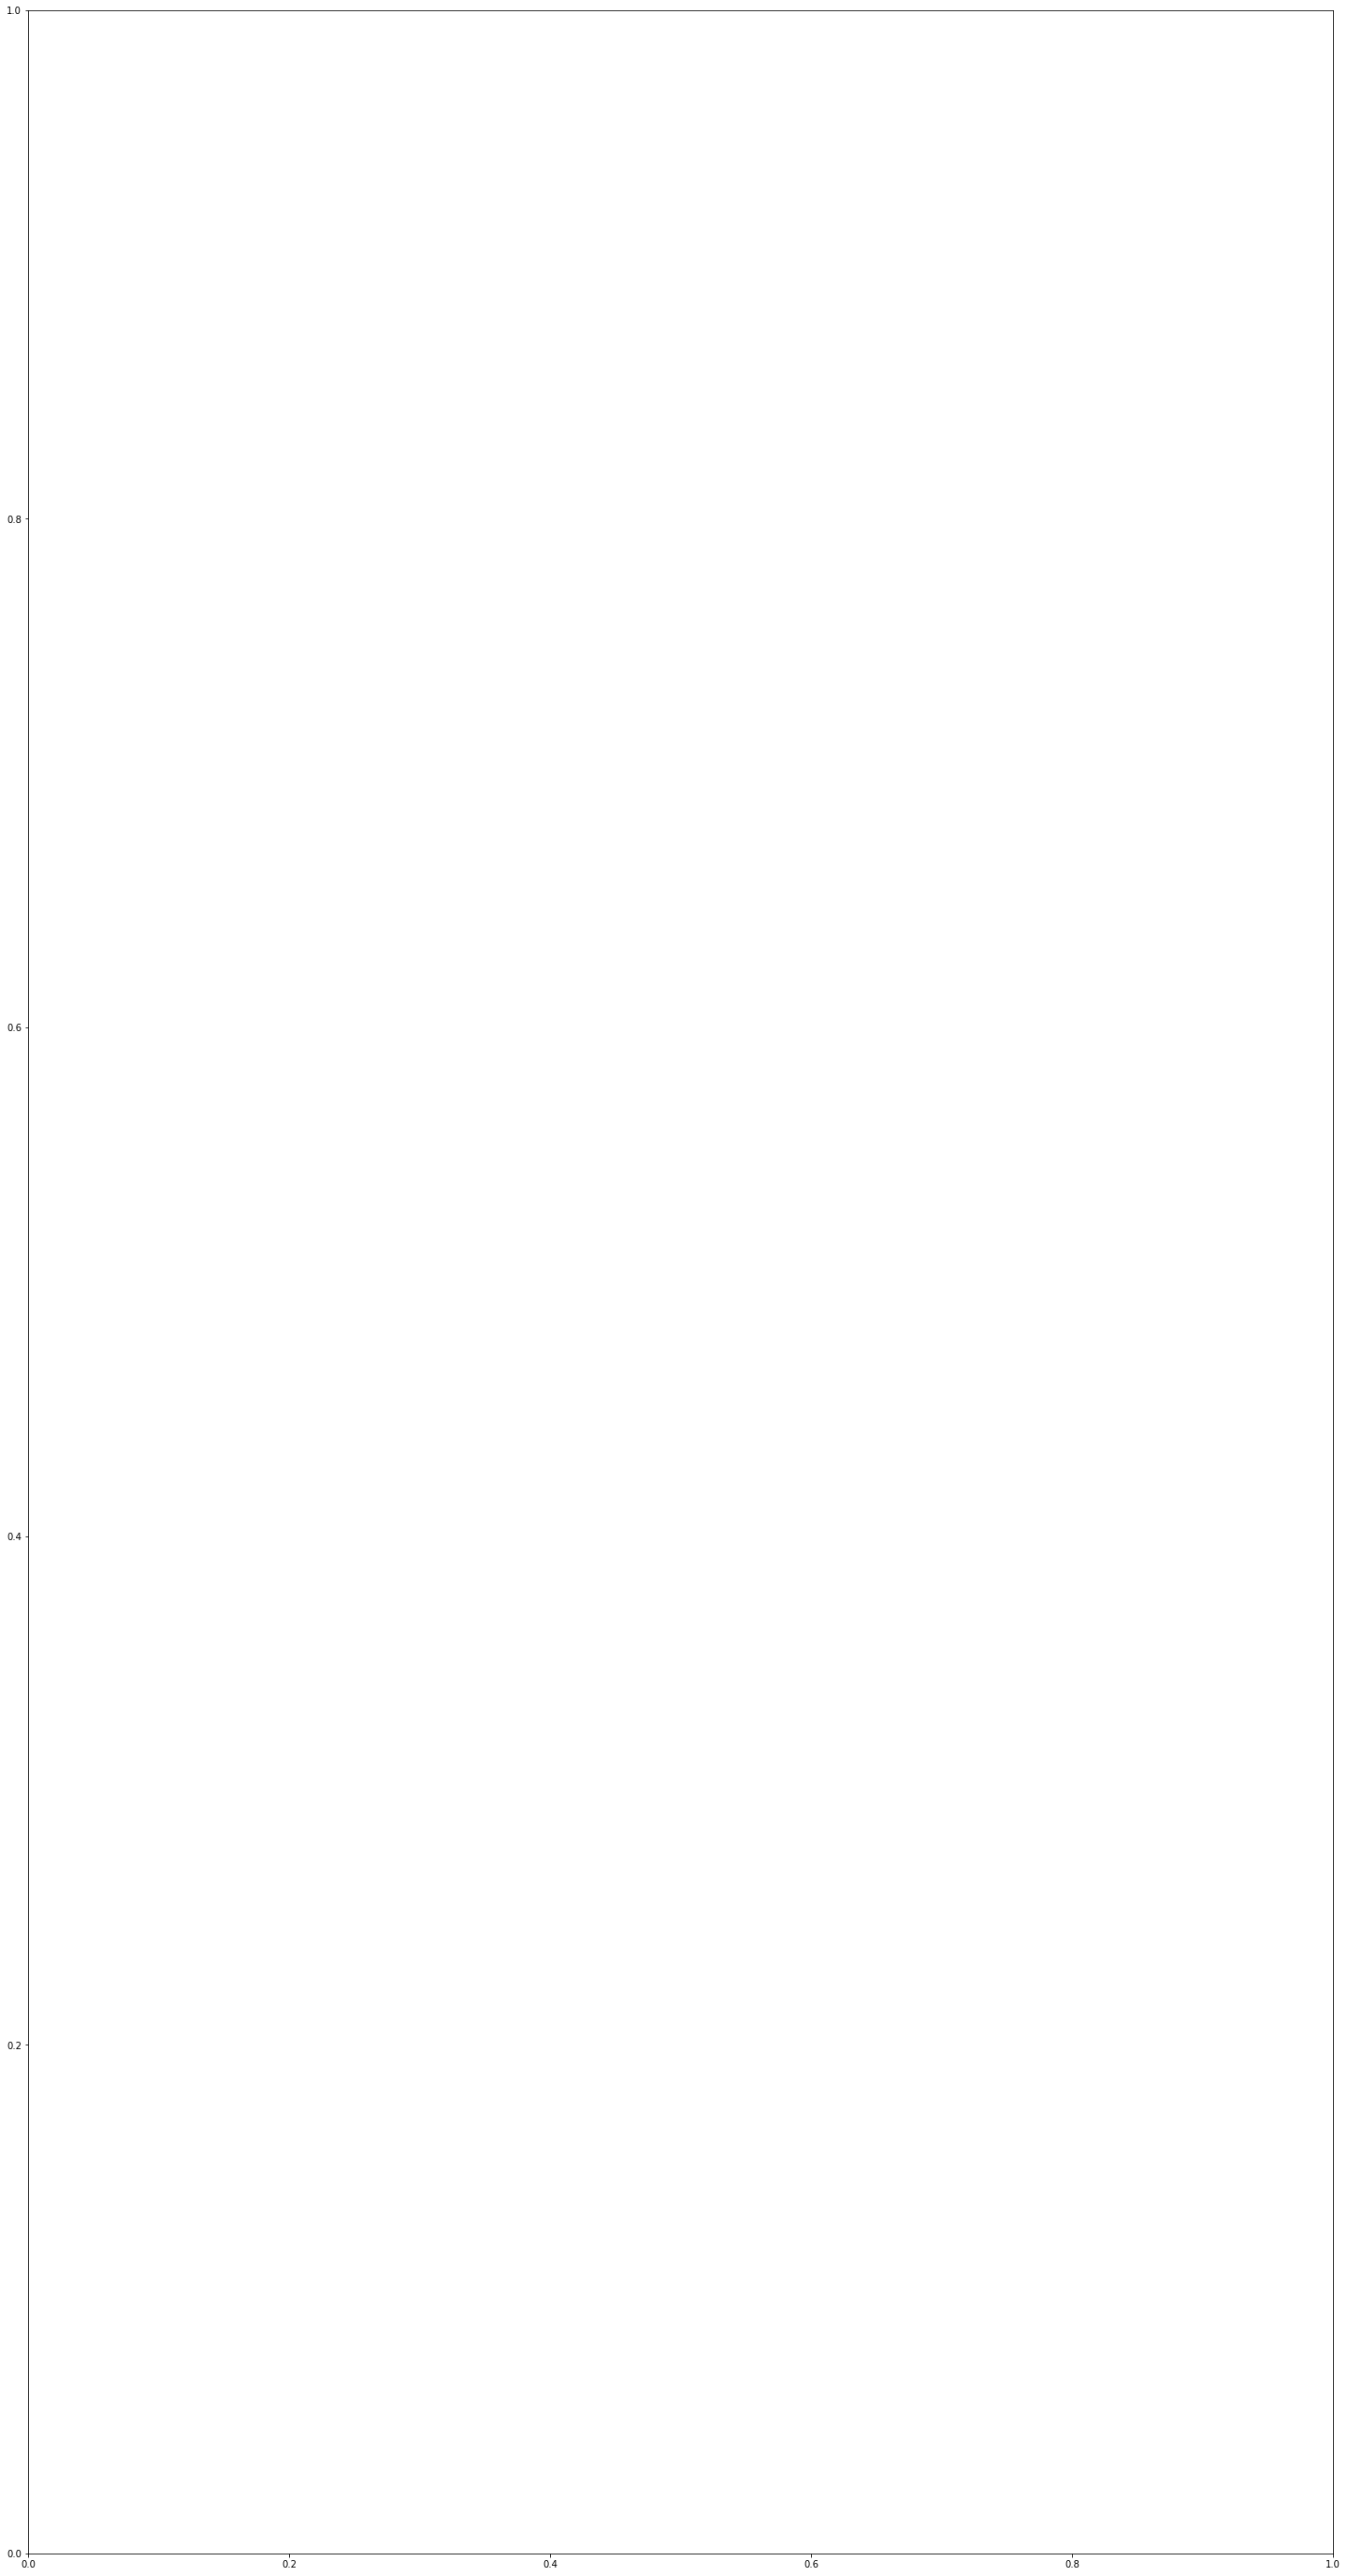

In [157]:
fig, ax = plt.subplots(figsize=(25, 50))
xgb.plot_importance(model_xgb, ax=ax)


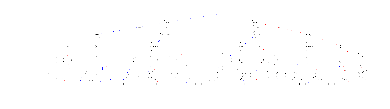

In [77]:
xgb.plot_tree(model_xgb, num_trees=2)

## Final model build and submission

Now that we have tested our models on the validation data, let's retrain with all the data before predicting on the test set

In [160]:
train_Y = train['price_doc']
train_X = train.drop('price_doc', axis=1)

trainXGB_final = xgb.DMatrix(train_X, label=train_Y)
testingXGB = xgb.DMatrix(testing)

model_xgb_final = xgb.train(best_params,trainXGB_final)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields timestamp, product_type, sub_area, culture_objects_top_25, thermal_power_plant_raion, incineration_raion, oil_chemistry_raion, radiation_raion, railroad_terminal_raion, big_market_raion, nuclear_reactor_raion, detention_facility_raion, water_1line, big_road1_1line, railroad_1line, ecology

In [162]:
train_X

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x12f617588>>
Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/xgboost/core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


id   timestamp  full_sq  life_sq  floor  max_floor  material  \
0          1  2011-08-20       43     27.0    4.0        NaN       NaN   
1          2  2011-08-23       34     19.0    3.0        NaN       NaN   
2          3  2011-08-27       43     29.0    2.0        NaN       NaN   
3          4  2011-09-01       89     50.0    9.0        NaN       NaN   
4          5  2011-09-05       77     77.0    4.0        NaN       NaN   
5          6  2011-09-06       67     46.0   14.0        NaN       NaN   
6          7  2011-09-08       25     14.0   10.0        NaN       NaN   
7          8  2011-09-09       44     44.0    5.0        NaN       NaN   
8          9  2011-09-10       42     27.0    5.0        NaN       NaN   
9         10  2011-09-13       36     21.0    9.0        NaN       NaN   
10        11  2011-09-16       36     19.0   12.0        NaN       NaN   
11        12  2011-09-16       38     19.0   11.0        NaN       NaN   
12        13  2011-09-17       43     28.0    4.0        NaN       NaN   
13        14  2011-09-19       31     31.0    4.0        NaN       NaN   
14        15  2011-09-19       31     21.0    3.0        NaN       NaN   
15        16  2011-09-20       51     31.0   15.0        NaN       NaN   
16        17  2011-09-20       47     31.0    4.0        NaN       NaN   
17        18  2011-09-20       42     28.0    2.0        NaN       NaN   
18        19  2011-09-22       59     33.0   10.0        NaN       NaN   
19        20  2011-09-22       44     29.0    4.0        NaN       NaN   
20        21  2011-09-22       74     44.0   10.0        NaN       NaN   
21        22  2011-09-22       39     39.0    7.0        NaN       NaN   
22        23  2011-09-23       48     34.0    6.0        NaN       NaN   
23        24  2011-09-23       32     18.0    3.0        NaN       NaN   
24        25  2011-09-23       34     19.0   11.0        NaN       NaN   
25        26  2011-09-24       45     29.0    9.0        NaN       NaN   
26        27  2011-09-26       35     20.0    4.0        NaN       NaN   
27        28  2011-09-26       38     20.0    6.0        NaN       NaN   
28        29  2011-09-26       73     38.0   15.0        NaN       NaN   
29        30  2011-09-27       42     27.0    3.0        NaN       NaN   
30        31  2011-09-27       40     20.0   12.0        NaN       NaN   
31        32  2011-09-27       81     46.0   24.0        NaN       NaN   
32        33  2011-09-28       38     34.0    2.0        NaN       NaN   
33        34  2011-09-28       31     18.0    4.0        NaN       NaN   
34        35  2011-09-28       39     19.0    1.0        NaN       NaN   
35        36  2011-09-28       39     20.0    1.0        NaN       NaN   
36        37  2011-09-29       37     19.0    9.0        NaN       NaN   
37        38  2011-09-30       27     27.0    4.0        NaN       NaN   
38        39  2011-09-30       33     18.0    2.0        NaN       NaN   
39        40  2011-09-30       33     18.0    9.0        NaN       NaN   
40        41  2011-09-30       45     30.0    5.0        NaN       NaN   
41        42  2011-09-30       54     30.0   10.0        NaN       NaN   
42        43  2011-10-01       40     25.0    3.0        NaN       NaN   
43        44  2011-10-01       59     42.0    8.0        NaN       NaN   
44        45  2011-10-01       77     45.0   10.0        NaN       NaN   
45        46  2011-10-01       42     22.0   24.0        NaN       NaN   
46        47  2011-10-03       38     23.0    4.0        NaN       NaN   
47        48  2011-10-03       36     18.0    5.0        NaN       NaN   
48        49  2011-10-03       44     28.0    2.0        NaN       NaN   
49        50  2011-10-03       37     19.0   11.0        NaN       NaN   
50        51  2011-10-03       51     33.0    1.0        NaN       NaN   
51        52  2011-10-03       37     19.0    6.0        NaN       NaN   
52        53  2011-10-03       46     29.0    9.0        NaN       NaN   
53        54  

In [79]:
predY_xgb_final = model_xgb_final.predict(testingXGB)

In [80]:
predY_xgb_final

array([ 5017127.5,  7546984.5,  5635180. , ...,  4911409. ,  5290043.5,
        7944847. ], dtype=float32)

In [81]:
submission = pd.DataFrame()
submission['id'] = range(30474,38136)
submission['price_doc'] = predY_xgb_final

sub_file = 'submission.csv'
submission.to_csv(sub_file, index=False)
